# **Import librabies**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

# **Read data**

In [2]:
application_train = pd.read_csv('application_train.csv')

In [3]:
train_df = application_train.copy()
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# **EDA**

In [4]:
train_df.duplicated(keep='first').values.any()

False

In [5]:
# Drop NA/ XNA/ Unknown
train_df.drop(['SK_ID_CURR','ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE', 'WEEKDAY_APPR_PROCESS_START'], axis=1, inplace=True)
train_df.drop(train_df.loc[train_df['CODE_GENDER']== 'XNA'].index, inplace=True)
train_df.drop(train_df.loc[train_df['NAME_FAMILY_STATUS']== 'Unknown'].index, inplace=True)
train_df.drop(train_df.loc[train_df['DAYS_EMPLOYED']== 365243].index, inplace=True) # 365243 is NA values ( https://www.kaggle.com/competitions/home-credit-default-risk/discussion/57247)
train_df.drop(train_df.loc[train_df['AMT_INCOME_TOTAL']== 117000000].index, inplace=True)
train_df.update(train_df[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].fillna(0.5))

In [6]:
percent_missing = train_df.isnull().sum() * 100 / len(train_df)
missing_value_df = pd.DataFrame({'column_name': train_df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
TARGET,TARGET,0.000000
REG_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,0.000000
REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_LIVE_CITY,0.000000
REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,0.000000
LIVE_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,0.000000
...,...,...
NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_AVG,69.311863
NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MEDI,69.311863
COMMONAREA_MODE,COMMONAREA_MODE,69.758458
COMMONAREA_AVG,COMMONAREA_AVG,69.758458


In [7]:
pct_over = []
pct = percent_missing.tolist()
for i in range(len(pct)):
    if pct[i] > 15:
        pct_over.append(train_df.columns.tolist()[i])

train_df.drop(pct_over, axis=1, inplace=True)
train_df.dropna(how='any',axis=0,inplace=True)

In [8]:
import seaborn as  sns
def barplot_mean(x, y, df, hue=None, order=None, hue_order=None):
    print(df.groupby(x)[y].mean())
    uniqs = df[x].nunique()

    if uniqs > 4:
        plt.figure(figsize=(16,4))

    sns.barplot(x=x, y=y, data=df, estimator=np.mean, hue=hue, order=order, hue_order=hue_order)
    plt.show()

In [9]:
# NAME_TYPE_SUITE
train_df.loc[train_df['NAME_TYPE_SUITE'] != 'Unaccompanied', 'NAME_TYPE_SUITE'] = 'Accompanied'
#barplot_mean('NAME_TYPE_SUITE','TARGET', train_df)

In [10]:
# NAME_INCOME_TYPE
train_df.loc[train_df['NAME_INCOME_TYPE'] != 'Working', 'NAME_INCOME_TYPE'] = 'NotWorking'
#barplot_mean('NAME_INCOME_TYPE','TARGET', train_df)

In [11]:
# NAME_HOUSING_TYPE
train_df.loc[train_df['NAME_HOUSING_TYPE'] != 'House / apartment', 'NAME_HOUSING_TYPE'] = 'Not Owner'
#barplot_mean('NAME_HOUSING_TYPE','TARGET', train_df)

In [12]:
# NAME_FAMILY_STATUS
train_df.loc[train_df['NAME_FAMILY_STATUS'] != 'Married', 'NAME_FAMILY_STATUS'] = 'Not Married'
#barplot_mean('NAME_FAMILY_STATUS','TARGET', train_df)

In [13]:
# NAME_EDUCATION_TYPE
train_df.loc[train_df['NAME_EDUCATION_TYPE'] != 'Lower secondary', 'NAME_EDUCATION_TYPE'] = 'From Secondary'
#barplot_mean('NAME_EDUCATION_TYPE','TARGET', train_df)

In [14]:
def cons_fts_vis(df,target):
    num_ft = df.dtypes[df.dtypes == 'int64'].index | df.dtypes[df.dtypes == 'float64'].index
    for column in list(num_ft):
        if len(df[column].unique()) > 2:  # continuos fts
            plt.figure(figsize=(16,4))
            plt.subplot(1,3,1)
            sns.distplot(df[column], hist = True, color = "#07247D", hist_kws = {'edgecolor':'black'})
            plt.xlabel(column)
            plt.ylabel('Density')
            plt.title(f'{column}  Distribution')

            plt.subplot(1,3,2)
            sns.boxplot(x=target, y=column, data =df, showmeans=True )
            plt.xlabel('Target')
            plt.ylabel(column)
            plt.title(f'{column}  Distribution')

            plt.subplot(1,3,3)
            counts, bins = np.histogram(df[column], bins=20, normed=True)
            cdf = np.cumsum (counts)
            plt.plot (bins[1:], cdf/cdf[-1])
            plt.title(f'{column}  cdf')
            plt.show()
            print()

In [15]:
# category --> onehot endcoding
cat_cols_encoded = []
cat_ft = train_df.dtypes[train_df.dtypes == 'object'].index
for col in list(cat_ft):
  cat_cols_encoded += [f"{col}_{cat}" for cat in list(train_df[col].unique()[1:])]

In [16]:
OHE = OneHotEncoder(sparse=False, handle_unknown='error',drop = 'first')
encoded_cols = OHE.fit_transform(train_df[cat_ft])

df_enc = pd.DataFrame(encoded_cols, columns=cat_cols_encoded)
train_df.reset_index(drop=True,inplace= True)
train_df_enc = train_df.join(df_enc)
train_df_enc.drop(cat_ft, axis=1, inplace=True)

In [17]:
# train test split
X,y = train_df_enc.drop(columns=['TARGET']), train_df_enc['TARGET']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [18]:
col_fts = [column for column in list(X_train.dtypes[X_train.dtypes == 'int64'].index | X_train.dtypes[X_train.dtypes == 'float64'].index) if len(X_train[column].unique()) > 2]

# **Scaling data**

In [19]:
# coutinuos --> scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[col_fts] = scaler.fit_transform(X_train[col_fts])
X_test[col_fts] = scaler.fit_transform(X_test[col_fts])

# **Handle imbalance data**

In [20]:
# fix imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

nm = NearMiss()
sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

# **Building model and evaluating**

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     39679
           1       0.54      0.00      0.00      3630

    accuracy                           0.92     43309
   macro avg       0.73      0.50      0.48     43309
weighted avg       0.88      0.92      0.88     43309



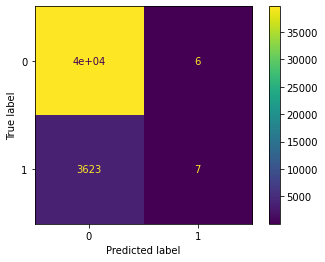

In [22]:
# KNN no Resample

knn_clf = KNeighborsClassifier(n_neighbors = 21)
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)

print(classification_report( y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
plt.close()

              precision    recall  f1-score   support

           0       0.94      0.55      0.70     39679
           1       0.12      0.64      0.20      3630

    accuracy                           0.56     43309
   macro avg       0.53      0.60      0.45     43309
weighted avg       0.87      0.56      0.65     43309



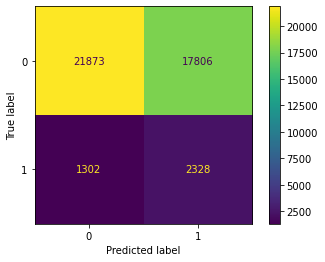

In [23]:
# KNN with SMOTE

knn_clf = KNeighborsClassifier(n_neighbors = 21)
knn_clf.fit(X_train_sm, y_train_sm)

y_pred_sm = knn_clf.predict(X_test)

print(classification_report( y_test, y_pred_sm))
cm = confusion_matrix(y_test, y_pred_sm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
plt.close()

              precision    recall  f1-score   support

           0       0.92      0.36      0.51     39679
           1       0.09      0.67      0.16      3630

    accuracy                           0.38     43309
   macro avg       0.51      0.52      0.33     43309
weighted avg       0.85      0.38      0.48     43309



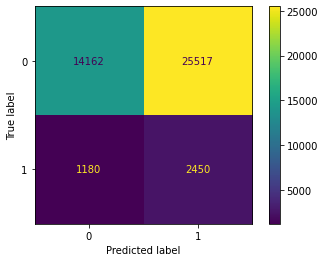

In [24]:
# KNN with NearMiss
knn_clf = KNeighborsClassifier(n_neighbors = 21)
knn_clf.fit(X_train_nm, y_train_nm)

y_pred_nm = knn_clf.predict(X_test)

print(classification_report( y_test, y_pred_nm))
cm = confusion_matrix(y_test, y_pred_nm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
plt.close()